In [1]:
import argparse
import os
import sys

from astropy.io import fits

import pint.models as models
import pint.fermi_toas as fermi
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

import scipy.optimize as op
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt

import pint.fitter as fitter
import pint.toa as toa
# import presto.psr_utils as pu
import pint.derived_quantities as pd
import pint.residuals as pr
import pint.simulation as ps
from pint.utils import FTest
from pint.plot_utils import phaseogram
from pint.eventstats import hmw
from pint.models import parameter as pp

from scipy.linalg import cho_solve,cho_factor,solve_triangular,LinAlgError

import astropy.time
from astropy.time import TimeDelta
from astropy.visualization import quantity_support

import copy
from pint.fitter import MaxiterReached, StepProblem
from pint.utils import FTest

import pint.logging
from loguru import logger as log

pint.logging.setup(level='INFO')

1

In [2]:
def phase_wrap(model,ts):
    res = pr.Residuals(ts,model)
    resids = res.phase_resids
    if np.diff(resids).max() > 0.5:
        log.warning('Phase wrap detected')
        for i in range(np.where(np.diff(resids)==np.diff(resids).max())[0][0]+1,len(ts)):
            ts['delta_pulse_number'][i] += -1.0
        res = pr.Residuals(ts,model)
    return res, ts

def res_plot(mjds,residuals,ts):
    quantity_support()
    plt.figure(figsize=(16,9))
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel('Residuals',fontsize = 16)
    plt.xlabel('MJDs',fontsize = 16)
    plt.errorbar(mjds,residuals.time_resids,yerr=ts.get_errors(),fmt='+')
    plt.title('Initial Residuals',fontsize=20)
    plt.grid()
    plt.show()

In [ ]:
def wave_fitter(model,ts,nwaves=1,show_plot=False):
    '''
    Does a iterative fit of a no red noise model adding waves with each iteration and compares the fitted model with the previous iteration using the F-test
    '''
    ts.compute_pulse_numbers(model)
    mjds = ts.get_mjds()
    residuals, ts = phase_wrap(model,ts)
    PM_values = []
    PM_values.append([0,model.PMRA.value,model.PMRA.uncertainty_value,model.PMDEC.value,model.PMDEC.uncertainty_value])
#     PM_values.append([0,model.PMELONG.value,model.PMELONG.uncertainty_value,model.PMELAT.value,model.PMELAT.uncertainty_value])
    if show_plot:
        res_plot(mjds,residuals,ts)
    tspan = mjds[-1]-mjds[0]
    for i in range(1,nwaves+1):
        log.info(f'Fitting {i} waves')
        # Setting up the waves within the model
        if i == 1:
            fit_model = copy.deepcopy(model)
            freq = 1/tspan
            fit_model.add_component(models.WaveX())
            fit_model.WXFREQ_0001.value = freq
        else:
            fit_model = copy.deepcopy(red_fitter.model)
            freq = i/tspan
            fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
        # Running the fitter
        try:
            red_fitter = fitter.Fitter.auto(ts,fit_model)
            red_fitter.fit_toas()
            red_fitter.update_model()
            red_fitter.model.CHI2.value = red_fitter.resids.chi2
            PM_values.append([i,red_fitter.model.PMRA.value,red_fitter.model.PMRA.uncertainty_value,red_fitter.model.PMDEC.value,red_fitter.model.PMDEC.uncertainty_value])   
#             PM_values.append([i,red_fitter.model.PMELONG.value,red_fitter.model.PMELONG.uncertainty_value,red_fitter.model.PMELAT.value,red_fitter.model.PMELAT.uncertainty_value])   
            if show_plot:
                red_fitter.plot()
        except (MaxiterReached, StepProblem) as e:
            log.warning(f'{e} encountered when fitting {i} waves')
            continue
            
#         # Stop criteria
#         if red_fitter.resids_init.rms_weighted()/red_fitter.resids.rms_weighted() < 3.0:
#             log.warning(f'The ratio of pre-fit and post-fit rms is less than 3.0 at {i} waves')
#             break
    return residuals, red_fitter, PM_values

def iterative_wave_fitter(model,ts,nwaves=1,show_plot=False):
    '''
    Does a iterative fit of a no red noise model adding waves with each iteration and compares the fitted model with the previous iteration using the F-test
    '''
    fresh_fit = False
    ts.compute_pulse_numbers(model)
    mjds = ts.get_mjds()
    residuals, ts = phase_wrap(model,ts)
    PM_values = []
    PM_values.append([0,model.PMRA.value,model.PMRA.uncertainty_value,model.PMDEC.value,model.PMDEC.uncertainty_value])
#     PM_values.append([0,model.PMELONG.value,model.PMELONG.uncertainty_value,model.PMELAT.value,model.PMELAT.uncertainty_value])
    if show_plot:
        res_plot(mjds,residuals,ts)
    tspan = mjds[-1]-mjds[0]
    try:
        model.components['WaveX']
    except KeyError:
        log.info(f'Model does not have any red noise components, Starting a fresh fit')
        fresh_fit=True
    if fresh_fit:
        for i in range(1,nwaves+1):
            log.info(f'Fitting {i} waves')
            # Setting up the waves within the model
            if i == 1:
                fit_model = copy.deepcopy(model)
                freq = 1/tspan
                fit_model.add_component(models.WaveX())
                fit_model.WXFREQ_0001.value = freq
            else:
                fit_model = copy.deepcopy(red_fitter.model)
                freq = i/tspan
                fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
            # Running the fitter
            try:
                red_fitter = fitter.Fitter.auto(ts,fit_model)
                red_fitter.fit_toas()
                red_fitter.update_model()
                red_fitter.model.CHI2.value = red_fitter.resids.chi2
                PM_values.append([i,red_fitter.model.PMRA.value,red_fitter.model.PMRA.uncertainty_value,red_fitter.model.PMDEC.value,red_fitter.model.PMDEC.uncertainty_value])   
#                 PM_values.append([i,red_fitter.model.PMELONG.value,red_fitter.model.PMELONG.uncertainty_value,red_fitter.model.PMELAT.value,red_fitter.model.PMELAT.uncertainty_value])   
                if show_plot:
                    red_fitter.plot()
            except (MaxiterReached, StepProblem) as e:
                log.warning(f'{e} encountered when fitting {i} waves')
                continue
    else:
        last_index = model.components['WaveX'].get_indices()[-1]
        fit_model = copy.deepcopy(model)
        if last_index >= nwaves:
            log.warning(f'The number of waves within the model is larger than the number of waves to be added')
            return None,None,None
        for i in range(last_index+1,nwaves+1):
            log.info(f'Fitting {i} waves')
            freq = i/tspan
            fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
            red_fitter = fitter.Fitter.auto(ts,fit_model)
            try:
                red_fitter.fit_toas()
            except (MaxiterReached, StepProblem) as e:
                log.warning(f'{e} encountered when fitting {i} waves')
                continue
            red_fitter.update_model()
            red_fitter.model.CHI2.value = red_fitter.resids.chi2
            fit_model = copy.deepcopy(red_fitter.model)
        
    return residuals, red_fitter, PM_values

In [16]:
model, ts = models.get_model_and_toas('J2028_wrn.par', 'J2028_wrn.tim')
# for i in model.free_params:
#     if i.startswith('F'):
#         model[i].frozen=True
initial_resids, f, PM_values = wave_fitter(model,ts,nwaves=5)

INFO     (__main__                      ): Fitting 1 waves
INFO     (pint.fitter                   ): For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'
INFO     (__main__                      ): Fitting 2 waves
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
INFO     (pint.fitter                   ): For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
INFO     (__main__                      ): Fitting 3 waves
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
INFO     (pint.fitter                   ): For narrowband TOAs without correlated errors a

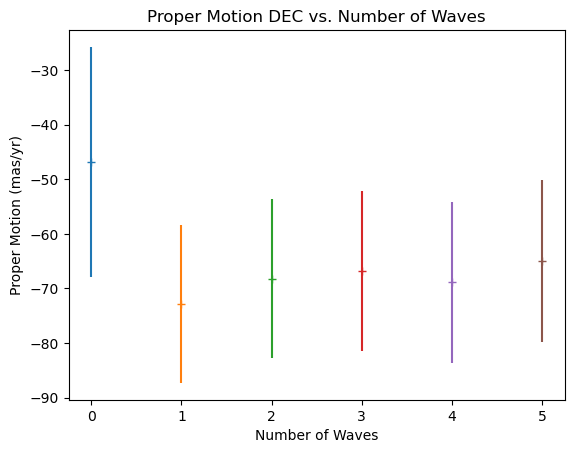

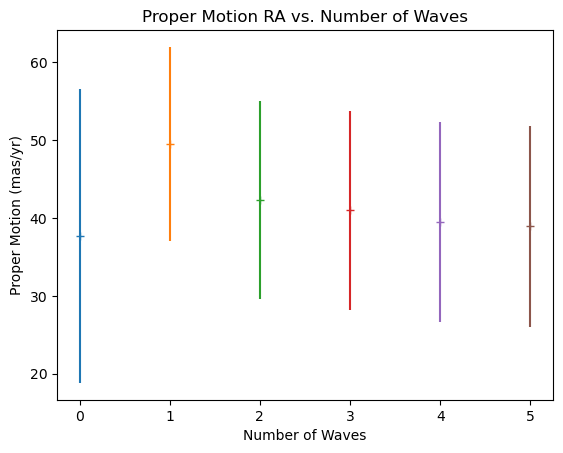

In [17]:
numwaves = np.arange(0,len(PM_values))
for i in range(len(numwaves)):
    plt.errorbar(numwaves[i],PM_values[:][i][3],yerr=PM_values[:][i][4],fmt='+')
plt.xlabel('Number of Waves')
plt.ylabel('Proper Motion (mas/yr)')
plt.title('Proper Motion DEC vs. Number of Waves')
plt.show()

for i in range(len(numwaves)):
    plt.errorbar(numwaves[i],PM_values[:][i][1],yerr=PM_values[:][i][2],fmt='+')
plt.xlabel('Number of Waves')
plt.ylabel('Proper Motion (mas/yr)')
plt.title('Proper Motion RA vs. Number of Waves')
plt.show()